In [ ]:
!pip install -q datasets transformers accelerate evaluate scikit-learn seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 38.6 MB/s eta 0:00:00


In [ ]:
import os, random, numpy as np, pandas as pd
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from transformers import DataCollatorWithPadding
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
N_TARGET = 25_000
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Load ONLY the train split
dataset = load_dataset("yelp_review_full", split="train", )  # 650k documents

# Map 1..5 stars -> 3 classes (0=NEG,1=NEU,2=POS) and keep text
def map_to_3(example):
    stars = example["label"] + 1
    if stars in [1, 2]:
        y = 0
    #elif stars == 3:
    #    y = 1
    else:
        y = 1
    return {"text": example["text"], "label3": y}

dataset = dataset.map(map_to_3, remove_columns=dataset.column_names)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

In [ ]:
# Stratified sample down to 100k rows so it runs faster
if N_TARGET > len(dataset):
    raise ValueError(f"Requested {N_TARGET} but dataset has only {len(dataset)} rows.")

df = dataset.to_pandas()
idx_all = np.arange(len(df))

sample_idx, _ = train_test_split(
    idx_all,
    train_size=N_TARGET,
    stratify=df["label3"].values,
    random_state=SEED
)

mini_ds = dataset.select(sample_idx)

# sanity check class distribution
mini_df = mini_ds.to_pandas()
print(mini_df["label3"].value_counts(normalize=True).sort_index())
print(len(mini_ds))

label3
0    0.4
1    0.6
Name: proportion, dtype: float64
25000


In [ ]:
# split dataset into train/test
mini_ds = mini_ds.train_test_split(test_size=0.15, seed=SEED)
mini_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label3'],
        num_rows: 21250
    })
    test: Dataset({
        features: ['text', 'label3'],
        num_rows: 3750
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from pathlib import Path

# Choose a compact, strong baseline
model_checkpoint = "microsoft/deberta-v3-small"

# Define labels
LABELS = ["NEGATIVE", "POSITIVE"]
id2label = {i: lbl for i, lbl in enumerate(LABELS)}
label2id = {lbl: i for i, lbl in enumerate(LABELS)}

# Load and modify config
config = AutoConfig.from_pretrained(model_checkpoint)
config.id2label = id2label
config.label2id = label2id
config.num_labels = 2
config

DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.57.1",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=150)

tokenized = mini_ds.map(tokenize, batched=True)
# Trainer expects column "labels"
tokenized = tokenized.rename_column("label3", "labels")

# Keep only necessary columns
cols_to_keep = ["input_ids", "attention_mask", "labels"]
tokenized = tokenized.remove_columns([c for c in tokenized["train"].column_names if c not in cols_to_keep])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/21250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3750 [00:00<?, ? examples/s]

In [ ]:
tokenized['train'].to_pandas()['input_ids'].apply(len).max()

np.int64(150)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, config=config, ignore_mismatched_sizes=True
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("./")

os.environ["WANDB_DISABLED"] = "true"  # keep W&B off

model_folder = base_folder / "models/sentiment/distilbert"
model_folder.mkdir(exist_ok=True, parents=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(logits_and_labels):
    """
    Compute sequence-level classification metrics (e.g., sentiment analysis).

    Args:
    - logits_and_labels (tuple): A tuple containing model logits and true labels.

    Returns:
    - dict: A dictionary containing accuracy, precision, recall, and f1-score (macro-averaged).
    """

    # Separate logits and true labels
    logits, true_labels = logits_and_labels

    # Obtain predicted class indices by selecting the highest logit for each example
    predicted_indices = np.argmax(logits, axis=-1)

    # Compute standard classification metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels,
        predicted_indices,
        average="macro",  # macro averages across classes for balanced comparison
        zero_division=0
    )

    accuracy = accuracy_score(true_labels, predicted_indices)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Base Finetuning Model
2 epochs; batch size 16; lr 4.5e-5

In [ ]:
# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    warmup_steps=1500,
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=32,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=4.5e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer
    gradient_accumulation_steps = 4,
    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy ='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=2000,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher
    bf16 = True,
    max_grad_norm = 1.0,
    gradient_checkpointing = False,
    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.accelerator.free_memory()
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.682200,0.670251,0.604267,0.302133,0.500000,0.376662
200,0.356000,0.343486,0.855467,0.848040,0.851686,0.849709
300,0.321700,0.358703,0.844533,0.843880,0.859499,0.842717
400,0.290300,0.310555,0.862133,0.863147,0.846273,0.852742
500,0.250300,0.278151,0.881067,0.874133,0.879962,0.876671
600,0.250700,0.327132,0.866933,0.870843,0.849314,0.857158


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i

TrainOutput(global_step=666, training_loss=0.39086885244638714, metrics={'train_runtime': 412.8346, 'train_samples_per_second': 103.015, 'train_steps_per_second': 1.613, 'total_flos': 1649362724687712.0, 'train_loss': 0.39086885244638714, 'epoch': 2.0})

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ROC-AUC: 0.870880447634432
              precision    recall  f1-score   support

    NEGATIVE      0.872     0.821     0.846      1484
    POSITIVE      0.887     0.921     0.904      2266

    accuracy                          0.881      3750
   macro avg      0.879     0.871     0.875      3750
weighted avg      0.881     0.881     0.881      3750



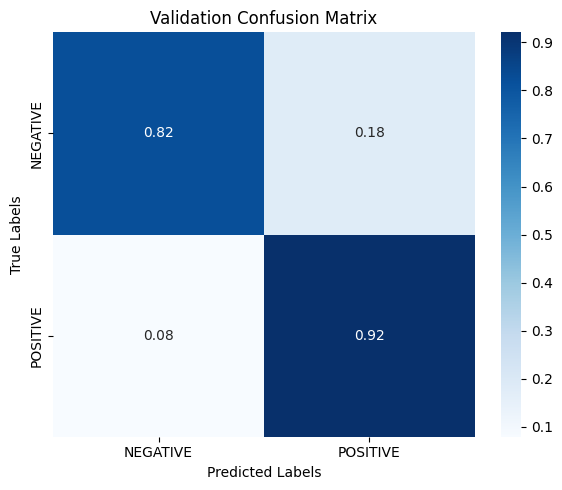

In [ ]:
#trainer.evaluate(tokenized["test"])
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

valid_output = trainer.predict(tokenized["test"])
preds = np.argmax(valid_output.predictions, axis=-1)
y_true = valid_output.label_ids

cm = confusion_matrix(y_true, preds, normalize='true')
print("ROC-AUC:", roc_auc_score(y_true, preds))
print(classification_report(y_true, preds, target_names=LABELS, digits=3))
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=LABELS, yticklabels=LABELS)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
mini_ds['test'][0]

{'text': "Ok, I know that some people really love this club, but I am not one of those people!  If I had to pay to get in to this club, I would still have asked for my money back.  There was 3 lines that were long as hell (that's to be expected in Las Vegas).  There were several people getting by saying that they knew a guy naed Raul.  The club was over populated and the music was horrible!!!  The most up to date song they played came out in 2002!  Having to go up to the 53rd floor was cool at first, but trying to get down made me feel like a prisoner!  I had 4 girls in my group and they wouldn't let all of us on the elevator.  One person was held back (literally).  We were only there for about an hour.  If you have anything else to do, do it!!!!",
 'label3': 0}

In [ ]:
tokenizer.decode(tokenized['test'][0].get('input_ids'))

"[CLS] Ok, I know that some people really love this club, but I am not one of those people! If I had to pay to get in to this club, I would still have asked for my money back. There was 3 lines that were long as hell (that's to be expected in Las Vegas). There were several people getting by saying that they knew a guy naed Raul. The club was over populated and the music was horrible!!! The most up to date song they played came out in 2002! Having to go up to the 53rd floor was cool at first, but trying to get down made me feel like a prisoner! I had 4 girls in my group and they wouldn't let all of us[SEP]"

In [ ]:
print(f'predicted: {preds[0]}\nactual: {y_true[0]}')

predicted: 0
actual: 0


# Training for another epoch

In [ ]:
training_args.num_train_epochs = 3

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.accelerator.free_memory()
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.232000,0.280685,0.884267,0.880014,0.877261,0.878573
200,0.195300,0.303594,0.879200,0.879348,0.866325,0.871659
300,0.202900,0.285181,0.884800,0.877926,0.884097,0.880592
400,0.208400,0.290752,0.882133,0.877992,0.874682,0.876245
500,0.188400,0.293607,0.889333,0.882353,0.890174,0.885559
600,0.191600,0.306329,0.886933,0.882526,0.880514,0.881486
700,0.197100,0.298968,0.882400,0.879672,0.873042,0.876015


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i

TrainOutput(global_step=700, training_loss=0.21750694036483764, metrics={'train_runtime': 320.0743, 'train_samples_per_second': 199.304, 'train_steps_per_second': 3.121, 'total_flos': 1733813699433312.0, 'train_loss': 0.21750694036483764, 'epoch': 2.1023325808878854})

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ROC-AUC: 0.8730420751624269
              precision    recall  f1-score   support

    NEGATIVE      0.869     0.828     0.848      1484
    POSITIVE      0.891     0.918     0.904      2266

    accuracy                          0.882      3750
   macro avg      0.880     0.873     0.876      3750
weighted avg      0.882     0.882     0.882      3750



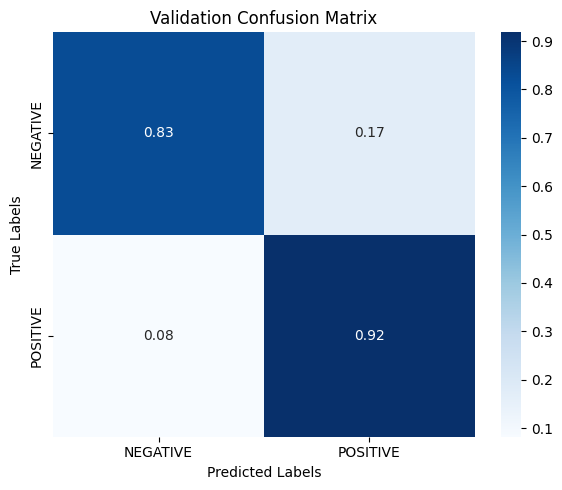

In [ ]:
valid_output = trainer.predict(tokenized["test"])
preds = np.argmax(valid_output.predictions, axis=-1)
y_true = valid_output.label_ids

cm = confusion_matrix(y_true, preds, normalize='true')
print("ROC-AUC:", roc_auc_score(y_true, preds))
print(classification_report(y_true, preds, target_names=LABELS, digits=3))
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=LABELS, yticklabels=LABELS)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

# Larger Batch Size + lr

In [ ]:
training_args.per_device_train_batch_size = 8
training_args.learning_rate = 9e-5

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.accelerator.free_memory()
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.191900,0.353231,0.877867,0.876479,0.866384,0.870680
200,0.198500,0.339501,0.888267,0.881292,0.888826,0.884410
300,0.151900,0.315952,0.882133,0.880114,0.871891,0.875493
400,0.175400,0.324789,0.884000,0.880238,0.876226,0.878100


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=400, training_loss=0.17838102340698242, metrics={'train_runtime': 570.995, 'train_samples_per_second': 111.679, 'train_steps_per_second': 3.494, 'total_flos': 496275739117152.0, 'train_loss': 0.17838102340698242, 'epoch': 0.602182913059842})

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.884
ROC-AUC: 0.8762263794091967
              precision    recall  f1-score   support

    NEGATIVE      0.864     0.839     0.851      1484
    POSITIVE      0.896     0.914     0.905      2266

    accuracy                          0.884      3750
   macro avg      0.880     0.876     0.878      3750
weighted avg      0.884     0.884     0.884      3750



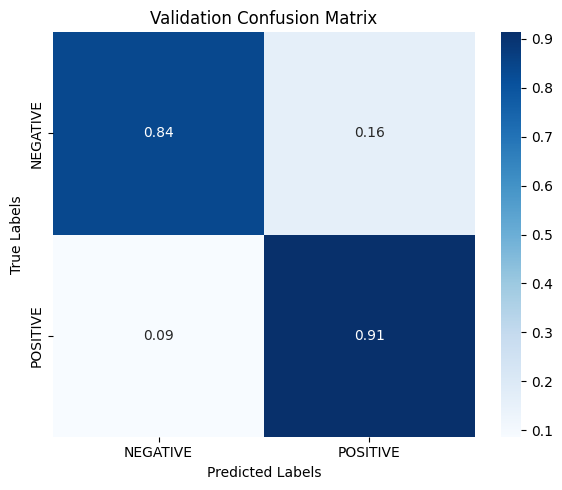

In [ ]:
valid_output = trainer.predict(tokenized["test"])
preds = np.argmax(valid_output.predictions, axis=-1)
y_true = valid_output.label_ids

cm = confusion_matrix(y_true, preds, normalize='true')
print("Accuracy:", accuracy_score(y_true, preds))
print("ROC-AUC:", roc_auc_score(y_true, preds))
print(classification_report(y_true, preds, target_names=LABELS, digits=3))
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=LABELS, yticklabels=LABELS)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

## Out of Box Model

In [ ]:
# Replace this with your own checkpoint
model_checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
text_classifier = pipeline(
    model=model_checkpoint
)
text_classifier.tokenizer.max_length = 150

Device set to use cpu


In [ ]:
text_classifier(tokenizer.decode(tokenized['test'][0].get('input_ids')))

[{'label': 'NEGATIVE', 'score': 0.9943875670433044}]

In [ ]:
from transformers.pipelines.pt_utils import KeyDataset
preds = []
for out in text_classifier(KeyDataset(mini_ds['test'], "text"), batch_size=8, truncation="only_first"):
    preds.append(out)

== Baseline (DistilBERT SST-2) ==
Accuracy: 0.82
ROC-AUC: 0.8362923255531791

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.71      0.91      0.80      1484
    POSITIVE       0.93      0.76      0.84      2266

    accuracy                           0.82      3750
   macro avg       0.82      0.84      0.82      3750
weighted avg       0.84      0.82      0.82      3750



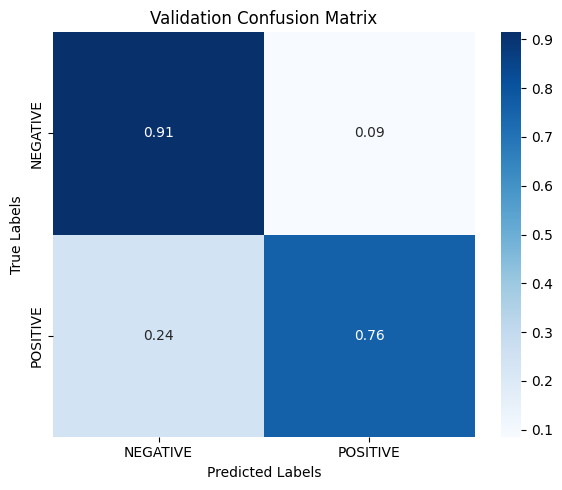

In [ ]:
def map_hf_preds_binary(preds):
    # Handle both 'POSITIVE/NEGATIVE' and 'LABEL_0/LABEL_1' styles
    def to_int(label):
        lbl = str(label).upper()
        if lbl in ("POSITIVE", "LABEL_1", "1"):
            return 1
        elif lbl in ("NEGATIVE", "LABEL_0", "0"):
            return 0
        else:
            raise ValueError(f"Unexpected label: {label}")

    y_pred = np.array([to_int(p['label']) for p in preds], dtype=int)
    # Probability of the positive class for ROC-AUC: if predicted POS, use score; else use 1-score
    y_score = np.array([p['score'] if to_int(p['label'])==1 else (1 - p['score']) for p in preds], dtype=float)
    return y_pred, y_score

y_pred_base, y_score_base = map_hf_preds_binary(preds)

# y_true: array-like of shape (n_samples,) with 0/1 labels
print("== Baseline (DistilBERT SST-2) ==")
print("Accuracy:", accuracy_score(y_true, y_pred_base))
print("ROC-AUC:", roc_auc_score(y_true, y_pred_base))
print("\nClassification report:\n", classification_report(y_true, y_pred_base, target_names=["NEGATIVE","POSITIVE"]))
cm = confusion_matrix(y_true, y_pred_base, normalize='true')
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=LABELS, yticklabels=LABELS)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()